Basic file reading and data exploration

In [1]:
import h5py
import numpy as np
import math
from scipy.spatial.transform import Rotation as R

# fname = 'd4/20220302_131424.hdf5'
# fname = '20220408_191041.hdf5'
# fname = '20220408_210049.hdf5' # 3 strokes
# fname = '20220409_184944.hdf5' # perpendicular drill angle
# fname = '20220409_185037.hdf5' # varying drill angle

# fname = 'Angles/45deg.hdf5' # 45 degree drill angle
fname = 'Angles/90deg.hdf5' # 90 degree drill angle
# fname = 'Angles/random.hdf5' # random drill angle

f = h5py.File(fname, 'r')
print('File keys', f.keys())
print(type(f))

File keys <KeysViewHDF5 ['burr_change', 'data', 'force', 'metadata', 'voxels_removed']>
<class 'h5py._hl.files.File'>


In [2]:
data = f['data']
print('Data keys', data.keys())
# print((data['depth'][()]).shape)
# print((data['l_img'][()]).shape)
# print((data['pose_main_camera'][()]).shape)
print((data['pose_mastoidectomy_drill'][()]).shape)
# print((data['r_img'][()]).shape)
print((data['segm'][()]).shape)
print((data['time'][()]).shape)

# Not necessary for our purposes

# b_cg = f['burr_change']
# print('Burr Change keys', b_cg.keys())

# meta = f['metadata']
# print('Metadata keys', meta.keys())
# print((meta['README'][()]))

force = f['force']
print('Force keys', force.keys())
print((force['time_stamp'][()]).shape)
print((force['wrench'][()]).shape)

v_rm = f['voxels_removed']
print('Voxels Removed keys', v_rm.keys())
print((v_rm['time_stamp'][()]).shape)
print((v_rm['voxel_color'][()]).shape)
print((v_rm['voxel_removed'][()]).shape)

# # Time differences between either time stamps unequal

# print((data['time'][1]) - (data['time'][0]))
# print((data['time'][435]) - (data['time'][434]))
# print((v_rm['time_stamp'][1]) - (v_rm['time_stamp'][0]))
# print((v_rm['time_stamp'][435]) - (v_rm['time_stamp'][434]))

# print(min(data['time'][()]), max(data['time'][()]))

print(min(data['time'][()]) == min(data['time'][()]))

Data keys <KeysViewHDF5 ['depth', 'l_img', 'pose_main_camera', 'pose_mastoidectomy_drill', 'r_img', 'segm', 'time']>
(83, 7)
(83, 480, 640, 3)
(83,)
Force keys <KeysViewHDF5 ['time_stamp', 'wrench']>
(42614,)
(42614, 3)
Voxels Removed keys <KeysViewHDF5 ['time_stamp', 'voxel_color', 'voxel_removed']>
(18361,)
(18361, 4)
(18361, 3)
True


Function implementation

In [3]:
def get_strokes(stream: np.ndarray, timepts: np.ndarray, k=6):
    stream = stream[:, :3]
    X_P = []

    # Compute k-cosines for each pivot point
    for j,P in enumerate(stream):
        
        # Cannot consider edge points as central k's
        if (j - k < 0) or (j + k >= stream.shape[0]):
            continue

        P_a = stream[j - k]
        P_c = stream[j + k]

        k_cos = np.dot(P_a, P_c) / (np.linalg.norm(P_a) * np.linalg.norm(P_c))
        k_cos = max(min(k_cos, 1), -1)
        X_P.append(180 - (math.acos(k_cos) * (180/np.pi)))

    # Detect pivot points
    mu = np.mean(X_P)
    sig = np.std(X_P)

    for i in range(k):
        
        X_P.insert(0, mu)
        X_P.append(mu)

    X_P = np.array(X_P)

    F_c = [1 if x_P > mu + sig else 0 for x_P in X_P]

    j = 0
    for i in range(1, len(F_c)):

        if F_c[i] == 1 and F_c[i-1] == 0:
            j += 1
        elif sum(F_c[i:i+k]) == 0 and j != 0:
            ind = math.floor(j/2)
            F_c[i-j:i] = [0] * j
            F_c[i-ind] = 1
            j = 0
        elif j != 0:
            j += 1

    st = np.insert(timepts[[s == 1 for s in F_c]], 0, min(timepts))

    return F_c, st

strokes, stroke_times = get_strokes(data['pose_mastoidectomy_drill'][()], data['time'][()])

In [4]:
def stats_per_stroke(stroke_arr: np.ndarray):
    
    mean = np.mean(stroke_arr)
    med_ = np.median(stroke_arr)
    max_ = np.max(stroke_arr)

    return mean, med_, max_

In [5]:
def stroke_force(strokes: np.ndarray, stroke_times: np.ndarray,
                force_stream: np.ndarray, force_times: np.ndarray):

    avg_stroke_force = []
    for i in range(sum(strokes)):

        stroke_mask = [ft >= stroke_times[i] and ft < stroke_times[i+1] for ft in force_times]
        stroke_forces = np.linalg.norm(force_stream[stroke_mask], axis=1)
        avg_stroke_force.append(np.mean(stroke_forces))

    return np.array(avg_stroke_force)
    

stroke_force(strokes, stroke_times, force['wrench'][()], force['time_stamp'][()])

array([0.        , 0.04895149, 0.28883978])

In [6]:
def stroke_length(strokes: np.ndarray, stream: np.ndarray):

    stream = stream[:, :3]
    
    lens = []
    inds = np.insert(np.where(strokes == 1), 0, 0)
    for i in range(sum(strokes)):
        stroke_len = 0
        curr_stroke = stream[inds[i]:inds[i+1]]
        for j in range(1, len(curr_stroke)):

            stroke_len += np.linalg.norm(curr_stroke[j-1] - curr_stroke[j])

        lens.append(stroke_len)

    return np.array(lens)

stroke_length(np.array(strokes), data['pose_mastoidectomy_drill'][()])

array([0.01883921, 0.04609494, 0.26347792])

In [7]:
def bone_removal_rate(strokes: np.ndarray, stroke_times: np.ndarray,
                        stream: np.ndarray, voxel_times: np.ndarray):
    
    vox_rm = []
    for i in range(sum(strokes)):

        stroke_voxels = [vt >= stroke_times[i] and vt < stroke_times[i+1] for vt in voxel_times]
        vox_rm.append(sum(stroke_voxels))

    rate = np.divide(np.array(vox_rm), stroke_length(np.array(strokes), stream))

    return rate

bone_removal_rate(strokes, stroke_times, data['pose_mastoidectomy_drill'][()], v_rm['time_stamp'][()])

array([    0.        , 47272.00235275, 54342.31538009])

In [8]:
def procedure_duration(timepts: np.ndarray):
    return (max(timepts) - min(timepts))

procedure_duration(data['time'][()])

42.55929708480835

[0.28051164 0.21789159 0.04654624]


<ipython-input-9-7229f30c8d60>:41: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rots.append(R.align_vectors(np.array(v).reshape((1,3)),


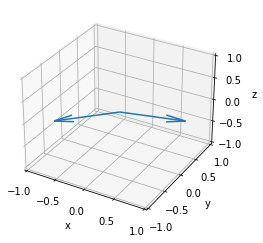

69.8843855470439



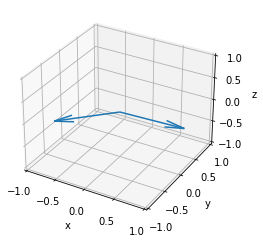

63.12853473604258



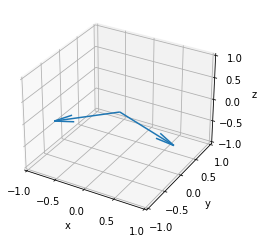

43.414802060385284



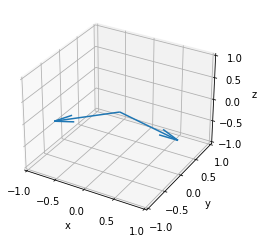

49.37032708293748



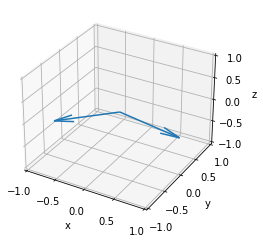

52.33307113816551



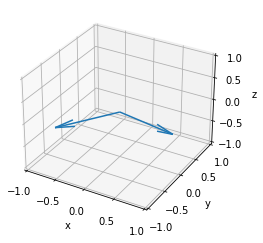

35.807241736894056



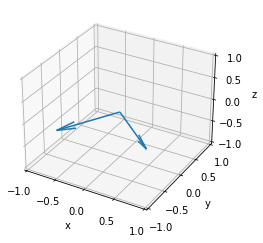

1.547501705024402



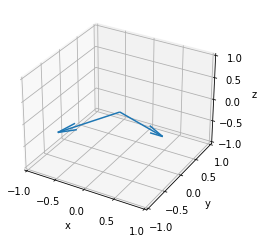

15.761039567626412



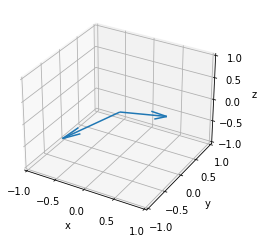

18.307832314738846



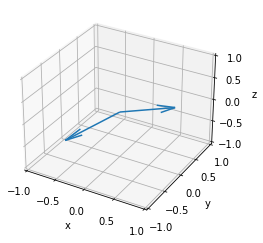

27.958531352971832



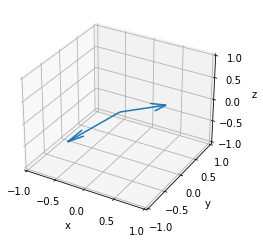

16.43605806665444



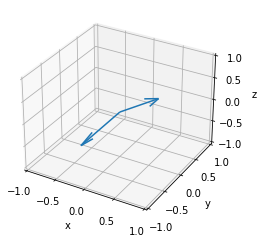

1.4686731121859538



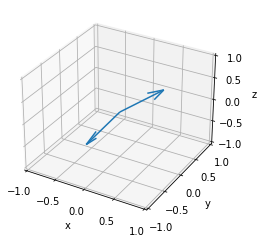

4.338959491971579



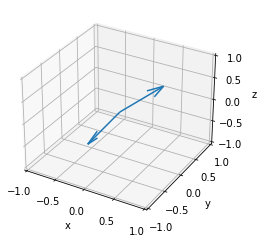

6.413604124327875



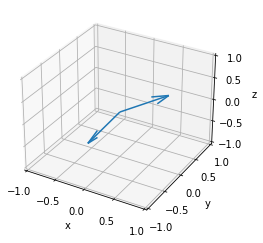

1.4642354415297802



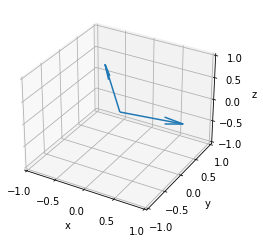

31.54781864776767



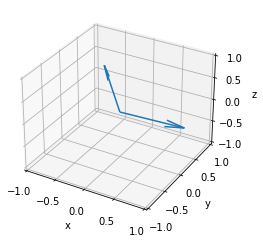

28.627981602993174



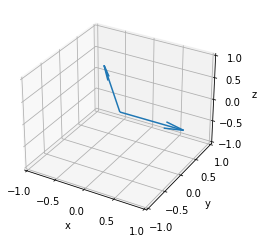

31.8326291609184



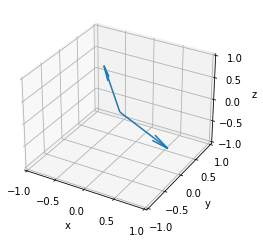

59.9899893786974



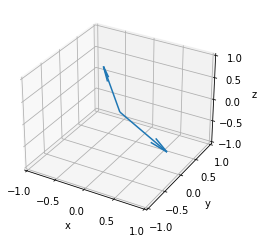

53.67688499458106



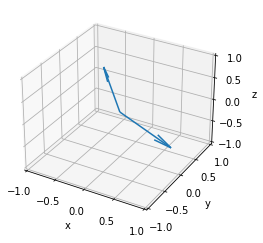

54.38838855246982



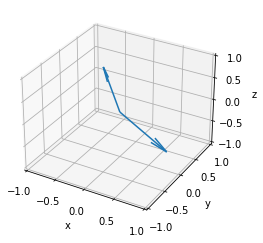

58.12678027853357



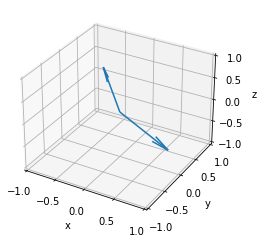

58.08669417808491



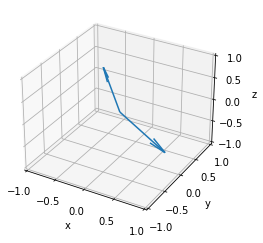

61.06723164101663



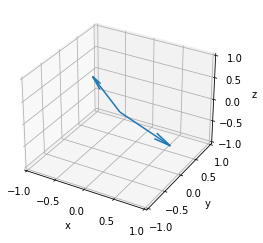

65.00300606770469



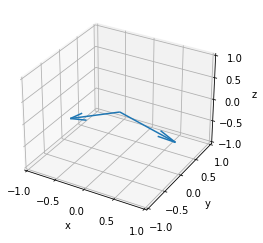

43.62374378226647



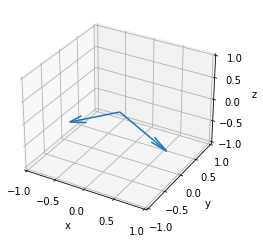

32.00399518957484



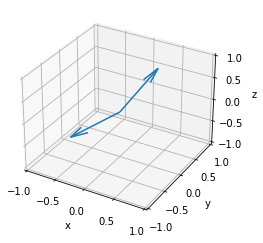

63.92506455701823



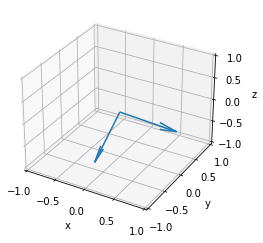

7.649535114839367



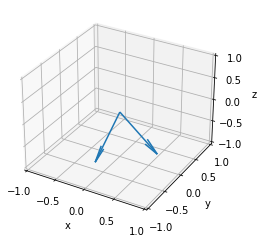

35.53574630856956



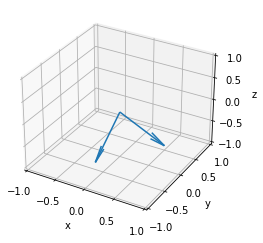

26.06714827418589



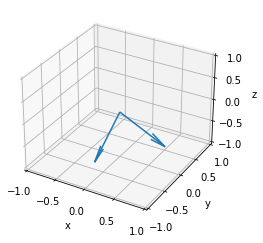

25.47313117545248



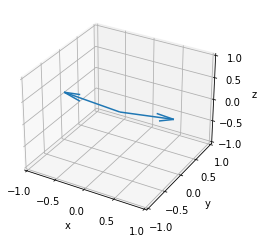

70.11910659473094



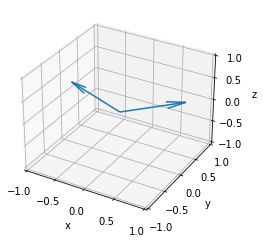

40.56047969462932

36.91000449036866


[69.8843855470439,
 63.12853473604258,
 43.414802060385284,
 49.37032708293748,
 52.33307113816551,
 35.807241736894056,
 1.547501705024402,
 15.761039567626412,
 18.307832314738846,
 27.958531352971832,
 16.43605806665444,
 1.4686731121859538,
 4.338959491971579,
 6.413604124327875,
 1.4642354415297802,
 31.54781864776767,
 28.627981602993174,
 31.8326291609184,
 59.9899893786974,
 53.67688499458106,
 54.38838855246982,
 58.12678027853357,
 58.08669417808491,
 61.06723164101663,
 65.00300606770469,
 43.62374378226647,
 32.00399518957484,
 63.92506455701823,
 7.649535114839367,
 35.53574630856956,
 26.06714827418589,
 25.47313117545248,
 70.11910659473094,
 40.56047969462932]

In [9]:
import matplotlib.pyplot as plt

def drill_orientation(stream: np.ndarray, timepts: np.ndarray,
                      force_stream: np.ndarray, force_times: np.ndarray):

    angles = []
    normals = []
    drill_vecs = []
    rots = []
    for i,t in enumerate(timepts):
        ind = np.argmin(np.abs(force_times - t))
        if np.isclose(np.abs(force_times[ind] - t), 0) and np.linalg.norm(force_stream[ind]) != 0:
            # print(sum([np.isclose(np.abs(v - voxel_times[ind]), 0) for v in voxel_times]))
            # if sum([np.isclose(v - voxel_times[ind], 0) for v in voxel_times]) >= 3:
            #     print(ind)
            #     print('howdy')
            #     return


            r = R.from_rotvec([0, 0, 0.9])
            
            # normal = R.from_quat(stream[i, 3:]).apply(force_stream[ind])
            normal = force_stream[ind]
            normal = np.divide(normal, np.linalg.norm(normal))
            normals.append(normal)

            # v = R.from_quat(stream[i, 3:]).apply([np.cos(0.9), np.sin(0.9), 0])
            # mat = [[np.cos(.9), -np.sin(.9), 0],
            #        [np.sin(.9), np.cos(.9), 0],
            #        [0, 0, 1]]

            # v = R.from_quat(stream[i, 3:]).apply(R.from_matrix(mat).apply([-13,0,0]))
            v = R.from_quat(stream[i, 3:]).apply([-1,0,0])
            v = np.divide(v, np.linalg.norm(v))
            drill_vecs.append(v)

            # normals.append(R.align_vectors(np.array([np.cos(0.9), np.sin(0.9), 0]).reshape((1,3)),
            #                                np.array([0, 0, 0]).reshape((1,3)))[0].apply(normal))

            # normals.append(r.apply(normal))
            rots.append(R.align_vectors(np.array(v).reshape((1,3)),
                    np.array(normal).reshape((1,3)))[0].as_rotvec())

    r = np.mean(rots, axis=0)
    print(r)
    r = R.from_rotvec(r)

    for i, v in enumerate(drill_vecs):

        n = normals[i]
        # n = r.apply(n)
        # print(rots[i])
        n = np.divide(n, np.linalg.norm(n))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        soa = np.array([np.insert(n, 0, (0, 0, 0)), np.insert(v, 0, (0, 0, 0))])

        X, Y, Z, U, V, W = zip(*soa)
        ax.quiver(X, Y, Z, U, V, W)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        # ax.view_init(30, 60)

        plt.show()

        angle = (np.arccos(np.clip(np.dot(n, v), -1.0, 1.0)) * (180/np.pi))
        if angle > 90:
            angle = 180 - angle

        print(90 - angle)
        print()
        angles.append(90 - angle)

    print(np.mean(angles))
    return angles

drill_orientation(data['pose_mastoidectomy_drill'][()], data['time'][()],
force['wrench'][()], force['time_stamp'][()])

In [10]:
import cffi
import pathlib

""" Build the CFFI Python bindings """
ffi = cffi.FFI()

this_dir = pathlib.Path().absolute()
h_file_name = this_dir / "EdtReader/EdtReader.h"
with open(h_file_name) as h_file:
    ffi.cdef(h_file.read())

ffi.set_source(
    "EDTread",
    # Since you're calling a fully-built library directly, no custom source
    # is necessary. You need to include the .h files, though, because behind
    # the scenes cffi generates a .c file that contains a Python-friendly
    # wrapper around each of the functions.
    '#include "EdtReader.h"',
    # The important thing is to include the pre-built lib in the list of
    # libraries you're linking against:
    libraries=["EdtReader"],
    library_dirs=[this_dir.as_posix()],
    extra_link_args=["-Wl,-rpath,."],
)

ffi.compile()

/Users/alexandraszewc/opt/anaconda3/lib/python3.8/site-packages/cffi/cparser.py:154: UserWarning: String literal found in cdef() or type source. String literals are ignored here, but you should remove them anyway because some character sequences confuse pre-parsing.
  warnings.warn("String literal found in cdef() or type source. "


CDefError: cannot parse "#include <iostream>"
<cdef source string>:1:1: Directives not supported yet

In [ ]:
import EDTread